In [17]:
from SLiCAP import *
# Always run SLiCAP from the project directory, this will use the correct path settings.
t1=time()

Warning less than two connections at node: 'out'.
No errors found for circuit: 'CS stage resistive noise' from file: 'CSresNoise.cir'.



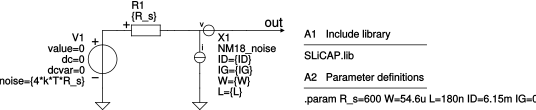

In [18]:
prj = initProject('CS stage noise with resistive source')
fileName = 'CSresNoise.cir'
i1 = instruction()
i1.setCircuit(fileName)
SVG(filename = img2html('CSresNoise.svg', 800))

In [19]:
HTML(netlist2html(fileName))

In [20]:
# Print circuit element data
HTML(elementData2html(i1.circuit))

In [21]:
# Set value of 1/f noise to zero
i1.defPar('KF_N18', 0)

In [22]:
# Get numeric values of 'I_D', 'IC' and 'IC_CRIT'
i1.simType = 'numeric'
I_D     = i1.getParValue('ID')
IC      = i1.getParValue('IC_X1')
IC_CRIT = i1.getParValue('IC_CRIT_X1')

In [23]:
# Define the drain current at critical inversion
I_D     = I_D*IC_CRIT/IC
i1.defPar('ID', I_D)

In [24]:
HTML(params2html(i1.circuit))

In [25]:
R_N   = i1.getParValue('R_N_X1')
R_s   = i1.getParValue('R_s')
f_T   = i1.getParValue('f_T_X1')
g_m   = i1.getParValue('g_m_X1')
Width = i1.getParValue('W')

In [26]:
htmlPage('Noise analysis')

maxima


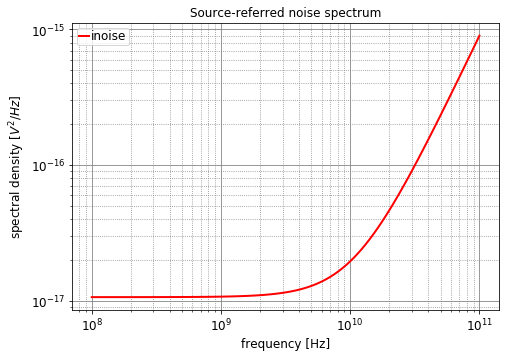

In [27]:
i1.setSource('V1')
i1.setDetector('V_out')
i1.setGainType('vi')
i1.setDataType('noise')
i1.setSimType('numeric')
print(ini.maxima)
noise_result = i1.execute()
plotSweep('Inoise', 'Source-referred noise spectrum', noise_result, 1e8, 1e11, 100, funcType = 'inoise', show=True)

In [28]:
# Calculate the noise figure at critical inversion and the given width
tot_inoise     = rmsNoise(noise_result, 'inoise', 1e9, 5e9)
tot_inoise_src = rmsNoise(noise_result, 'inoise', 1e9, 5e9, source = noise_result.source)
HTML(noise2html(noise_result))

In [29]:
NF           = 20*sp.log(tot_inoise/tot_inoise_src)/sp.log(10)
print("The noise figure equals: %s [dB]."%(sp.N(NF, ini.disp)))

The noise figure equals: 0.6526 [dB].


In [30]:
# We will now calculate the width W at which we will have the best noise performance.
# Define the variable 'W' in the notebook environment
W               = sp.Symbol('W')
i1.delPar('W')        # delete the numeric definition of the width
# We will keep the inversion coefficient at critical inversion, hence we scale the
# current with the width.
# Please know that not scaling the current results in expressions that cannot be integrated symbolically.
# We will then need numeric methods for determination of the optimum width.
i1.defPar('ID', I_D*W/Width)
noise_w = i1.execute() # calculate the noise spectra as a function of W and f
# Calculate the noise figure as a function of W over a frequency range from 'fmin' to 'fmax':
f_min = sp.Symbol('f_min')
f_max = sp.Symbol('f_max')
rms_noise_w        = rmsNoise(noise_w, 'inoise', f_min, f_max)
rms_noise_w_source = rmsNoise(noise_w, 'inoise', f_min, f_max, noise_w.source)
# We will now calculate the noise figure as a function of 'W', 'f_min' and 'f_max':
# We will use the variance instead of the RMS value:
NF_W            = (rms_noise_w/rms_noise_w_source)**2
# We will now calculate the optimum width as a function of 'fmin' and 'fmax':
W_opt           = sp.solve(sp.diff(NF_W, W), W)
# The sympy solve function returns a list with solutions, we will print the ones
# that are positive over the frequency range of interest.
for w in W_opt:
    w = sp.N(w.subs([(f_min, 1e9), (f_max, 5e9)]), ini.disp)
    if w > 0:
        print(w)

4.738e-5


In [31]:
# The noise figure over the frequency range of interest, as a function of the width is:
HTML('$' + sp.latex(roundN(sp.expand(NF_W.subs([(f_min, 1e9), (f_max, 5e9)])))) + '$')

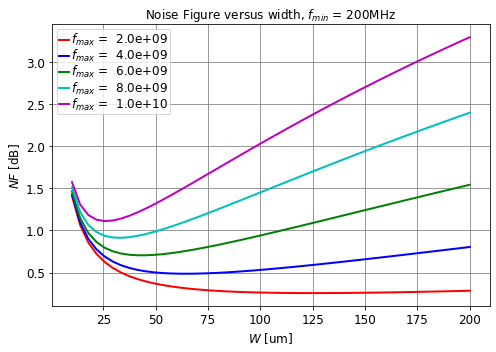

5.687124013900757 s


In [32]:
# Create a plot of the noise figure versus the with for different values of f_max and f_min = 1G
# Define the plot parameters, 'fw', 'W' and 'fmax'
i1.defPar('W', w)
i1.defPar('f_max', '10G')
i1.defPar('NF', 10*sp.log(NF_W.subs([(f_min, 2e8)]))/sp.log(10))
# Define the step parameters
i1.setStepVar('f_max')
i1.setStepStart('2G')
i1.setStepStop('10G')
i1.setStepMethod('lin')
i1.setSimType('numeric')
i1.setStepNum(5)
i1.stepOn()
result = i1.execute()
# Plot the function
fig_NF_W = plotSweep('NF_W', 'Noise Figure versus width, $f_{min}$ = 200MHz', result, 10, 200, 50, sweepVar = 'W', sweepScale = 'u', funcType = 'param', xUnits = 'm', yVar = 'NF', yUnits = 'dB', show = True)
t2 = time()
print(t2-t1, 's')